In [2]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("darkgrid")

In [5]:
df = pd.read_csv("grid_all_healthseek_events.csv")
lookup = pd.read_csv("grid_lookup.csv")

df = df.merge(lookup[["grid_cell", "pop"]], on="grid_cell", how="left")

In [7]:
df["year"] = df["fulldate"].apply(lambda x: np.float(x[:4])).astype(np.int)

In [13]:
df["pop_cov"] = df["pop"]*df["cov_newclin_youth"]

In [14]:
foo = df.groupby("year").agg({"pop": "sum", "pop_cov": "sum"}).reset_index()
foo["cov_all"] = foo["pop_cov"]/foo["pop"]

In [15]:
foo

,year,pop,pop_cov,cov_all
0,2010,321537.0,174563.629669,0.542904
1,2014,321537.0,211026.692198,0.656306


## Fill in rest of spline using ITN scale up

### Add smoothed version of spline

In [16]:
spline_df = pd.read_csv("southern_historical_itn.csv")

In [18]:
def fit_lowess_spline(x, y, frac=0.67, return_error=False, percentile_top=80, percentile_bottom=20):
    # From https://james-brennan.github.io/posts/lowess_conf/
    from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess

    def smooth(x, y, xgrid, frac=0.67):
        samples = np.random.choice(len(x), 50, replace=True)
        y_s = y[samples]
        x_s = x[samples]
        y_sm = sm_lowess(y_s, x_s, frac=frac, it=5,
                         return_sorted=False)
        # regularly sample it onto the grid
        y_grid = scipy.interpolate.interp1d(x_s, y_sm,
                                            fill_value='extrapolate')(xgrid)
        return y_grid

    if not return_error:
        sm_x, sm_y = sm_lowess(y, x, frac=frac, return_sorted=True).T
        return sm_x, sm_y
    elif return_error:
        xgrid = np.linspace(x.min(), x.max())
        K = 100
        smooths = np.stack([smooth(x, y, xgrid, frac=frac) for k in range(K)]).T

        mean = np.nanmean(smooths, axis=1)
        #         median = np.nanmedian(smooths, axis=1)
        q_top = np.nanpercentile(smooths, percentile_top, axis=1)
        q_bot = np.nanpercentile(smooths, percentile_bottom, axis=1)

        return xgrid, mean, q_bot, q_top


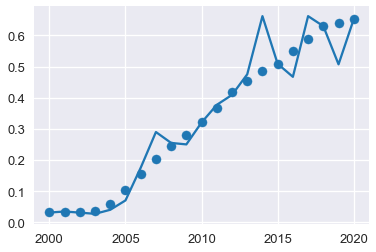

In [24]:
x = spline_df["year"]
y = spline_df["cov_all"]

plt.scatter(xs,ys)
plt.plot(x,y)

xs,ys = fit_lowess_spline(x,y,frac=0.3)

In [26]:
spline_df["cov_smoothed"] = ys

In [28]:
spline_df.to_csv("southern_historical_itn.csv", index=False)

### Now apply smoothed spline to healthseeking

In [37]:
s = np.array(spline_df["cov_smoothed"][spline_df["year"]<=2010])
s_rescale = s*0.542904/np.max(s)
print(s_rescale)

[0.05491942 0.0540625  0.05376928 0.06020986 0.10100293 0.17406264
 0.26116214 0.344639   0.41176209 0.47341052 0.542904  ]
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020]


[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020]
[0.05491942 0.0540625  0.05376928 0.06020986 0.10100293 0.17406264
 0.26116214 0.344639   0.41176209 0.47341052 0.542904   0.542904
 0.542904   0.542904   0.656306   0.656306   0.656306   0.656306
 0.656306   0.656306   0.656306  ]


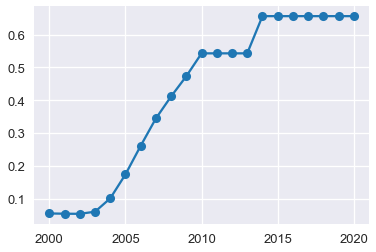

In [49]:
y = np.arange(2000,2021)
v = np.append(s_rescale, [np.max(s_rescale)]*3)
v = np.append(v, [0.656306]*7)
print(y)
print(v)

plt.plot(y,v, marker='o')

In [50]:
hs_df = pd.DataFrame({
    "year": y,
    "cov_newclin_youth": v
})

In [55]:
hs_df.to_csv("southern_historical_hs.csv", index=False)

In [57]:
for index, row in hs_df.iterrows(): 
    print(row["year"])

2000.0
2001.0
2002.0
2003.0
2004.0
2005.0
2006.0
2007.0
2008.0
2009.0
2010.0
2011.0
2012.0
2013.0
2014.0
2015.0
2016.0
2017.0
2018.0
2019.0
2020.0
